In [149]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from backtesting import Backtest, Strategy

In [150]:
df = yf.download("MSFT")
df = df.loc["2017-12-12":,:]
df['change_tomorrow'] = df["Adj Close"].pct_change(-1) * 100 * -1
df = df.dropna().copy()
df

[*********************100%***********************]  1 of 1 completed
/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_28264/79893226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change_tomorrow'] = df["Adj Close"].pct_change(-1) * 100 * -1


,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2017-12-12,85.309998,86.050003,85.080002,85.580002,79.449409,23924100,-0.269459
2017-12-13,85.739998,86.000000,85.169998,85.349998,79.235901,22062700,-0.779337
2017-12-14,85.430000,85.870003,84.529999,84.690002,78.623161,19306000,2.487072
2017-12-15,85.260002,87.089996,84.879997,86.849998,80.628448,53936700,-0.544128
2017-12-18,87.120003,87.500000,86.230003,86.379997,80.192101,22283800,-0.640759
...,...,...,...,...,...,...,...
2024-09-19,441.230011,441.500000,436.899994,438.690002,438.690002,21706600,-0.785722
2024-09-20,437.220001,439.239990,434.220001,435.269989,435.269989,55167100,-0.405984
2024-09-23,434.279999,436.459991,430.390015,433.510010,433.510010,15128900,-1.011253


In [151]:
target = df.change_tomorrow
explanatory = df[['Open','High','Low','Close','Volume']]

In [152]:
X_train, X_test, y_train, y_test = train_test_split(explanatory, target, test_size=0.2, random_state=42)

[Text(0.7576718639378227, 0.9705882352941176, 'Volume <= 56105050.0\nsquared_error = 3.413\nsamples = 1365\nvalue = 0.056'),
 Text(0.5588011658233384, 0.9117647058823529, 'Close <= 85.18\nsquared_error = 2.678\nsamples = 1312\nvalue = 0.088'),
 Text(0.6582365148805805, 0.9411764705882353, 'True  '),
 Text(0.48533871085290686, 0.8529411764705882, 'Open <= 87.57\nsquared_error = 0.307\nsamples = 2\nvalue = 3.041'),
 Text(0.48400604385307344, 0.7941176470588235, 'squared_error = 0.0\nsamples = 1\nvalue = 2.487'),
 Text(0.4866713778527403, 0.7941176470588235, 'squared_error = -0.0\nsamples = 1\nvalue = 3.595'),
 Text(0.6322636207937697, 0.8529411764705882, 'Volume <= 37795750.0\nsquared_error = 2.668\nsamples = 1310\nvalue = 0.084'),
 Text(0.4893367118524071, 0.7941176470588235, 'Volume <= 30885250.0\nsquared_error = 2.27\nsamples = 1150\nvalue = 0.047'),
 Text(0.37601902173913043, 0.7352941176470589, 'Volume <= 24311450.0\nsquared_error = 1.905\nsamples = 945\nvalue = 0.108'),
 Text(0.267

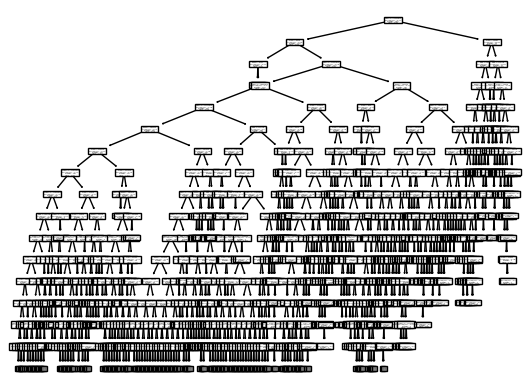

In [153]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X=X_train,y=y_train)
plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_, max_depth=15)

In [154]:
r_squared = model_dt.score(X=X_test,y=y_test)
print(f"R^2: {r_squared}")

R^2: -1.3345480499713656


In [155]:
scores = cross_val_score(model_dt, explanatory, target, cv=5)
print(f"Cross-validated R^2 score: {scores.mean():.4f}")

Cross-validated R^2 score: -1.3095


Backtesting

In [165]:
class Regression(Strategy):  
    def init(self):
        self.model = model_dt 
        self.already_bought = False

    def next(self):
        latest_data = {
            'Open': self.data.Open[-1],
            'High': self.data.High[-1],
            'Low': self.data.Low[-1],
            'Close': self.data.Close[-1],
            'Volume': self.data.Volume[-1]
        }
        explanatory_today = pd.DataFrame([latest_data])
        
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > 5 and not self.already_bought:  
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < -6 and self.already_bought:  
            self.sell()
            self.already_bought = False

In [166]:
bt = Backtest(df, Regression, cash=10000, commission=0.002, exclusive_orders=True) 
stats = bt.run()
stats

Start                     2017-12-12 00:00:00
End                       2024-09-25 00:00:00
Duration                   2479 days 00:00:00
Exposure Time [%]                   87.170475
Equity Final [$]                 17372.468194
Equity Peak [$]                  18881.668634
Return [%]                          73.724682
Buy & Hold Return [%]              404.919346
Return (Ann.) [%]                    8.495103
Volatility (Ann.) [%]                34.68653
Sharpe Ratio                         0.244911
Sortino Ratio                        0.404016
Calmar Ratio                         0.137865
Max. Drawdown [%]                  -61.619177
Avg. Drawdown [%]                   -4.351151
Max. Drawdown Duration     1584 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                   13
Win Rate [%]                        38.461538
Best Trade [%]                      78.314848
Worst Trade [%]                    -23.661761
Avg. Trade [%]                    

Links to the dashboard with the trading performance

In [160]:
bt.plot()

Row(id='4467', ...)